In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import model_from_json
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization,Input, Add , Activation, LSTM, Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint 


In [3]:
train_data = pd.read_csv("./train.csv")
train_shape = train_data.shape
train_data.head()


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:

test_data = pd.read_csv("./test.csv")
test_shape = test_data.shape
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


First shot. See if there is a direct variable correlation 

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
    
Almost all non-diagonal values are 0

In [5]:
data = train_data.append(test_data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(201), object(1)
memory usage: 619.5+ MB


In [7]:
data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.100490,10.669326,-1.625933,10.711322,6.792372,11.077366,-5.057938,5.412056,16.537496,0.280648,...,3.212103,7.448339,1.926891,3.326895,17.995376,-0.137873,2.297117,8.910293,15.869952,-3.286439
std,0.300653,3.038398,4.045275,2.637393,2.048028,1.619805,7.866274,0.865652,3.421286,3.333002,...,4.555632,3.024243,1.479193,3.993813,3.137905,1.429530,5.450356,0.921266,3.009828,10.418385
min,0.000000,0.188700,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.216400,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-39.457800
25%,0.000000,8.448900,-4.720800,8.729700,5.242175,9.886975,-11.200825,4.770200,13.938200,-2.310825,...,-0.077200,5.161900,0.886700,0.586075,15.632400,-1.165900,-1.947800,8.255800,13.838500,-11.171300
50%,0.000000,10.518950,-1.599400,10.570000,6.823700,11.104500,-4.833700,5.388500,16.439800,0.383100,...,3.181700,7.363700,1.897000,3.410900,17.967100,-0.167600,2.406800,8.890600,15.939200,-2.769700
75%,0.000000,12.748225,1.350025,12.505300,8.326000,12.256800,0.934700,6.004300,19.099000,2.934025,...,6.373200,9.521700,2.952800,6.191400,20.393800,0.834000,6.539300,9.594900,18.055325,4.889400
max,1.000000,22.323400,10.376800,19.353000,13.188300,16.671400,17.253700,8.447700,28.292800,10.151300,...,20.359000,16.716500,8.402400,18.281800,27.947800,4.545400,18.321500,12.275800,26.538400,28.500700


In [8]:
data['target'].unique()

array([ 0.,  1., nan])

This seems to be a binary classification problem, having 0 for some values and 1 for others

In [9]:
data = data.drop(columns="ID_code")

<AxesSubplot:ylabel='var_0'>

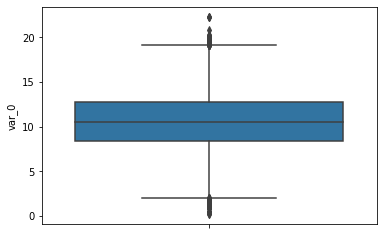

In [10]:
sns.boxplot(y=data['var_0'])

<AxesSubplot:ylabel='var_1'>

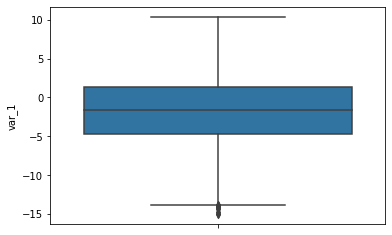

In [11]:
sns.boxplot(y=data['var_1'])

<AxesSubplot:ylabel='var_23'>

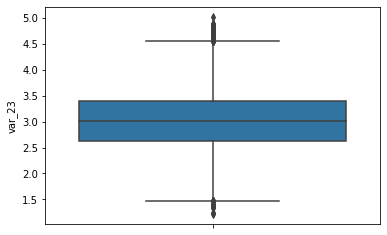

In [12]:
sns.boxplot(y=data['var_23'])

Choosen randomly a set of columns to see their distribution. 

<AxesSubplot:xlabel='var_23', ylabel='Count'>

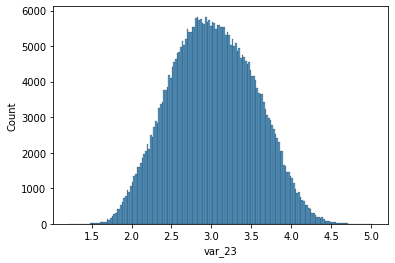

In [13]:
sns.histplot(data['var_23'])

<AxesSubplot:xlabel='var_23', ylabel='Count'>

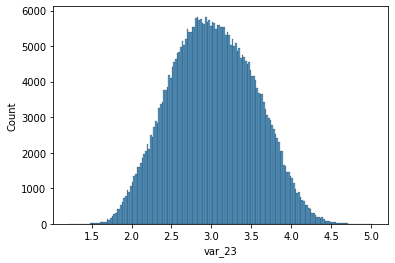

In [14]:
sns.histplot(data['var_23'])

<AxesSubplot:xlabel='var_0', ylabel='Count'>

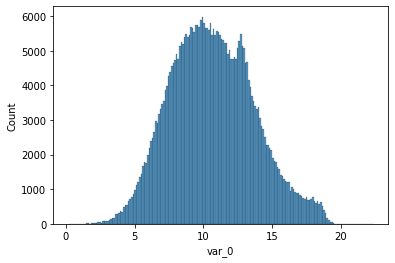

In [15]:
sns.histplot(data['var_0'])

Let's try a simple approach, normalizing some data using L2

In [16]:
from sklearn.preprocessing import Normalizer 

x = data.drop(columns="target")


scaler = Normalizer('l2') 
scaler.fit(x) 
x_scaled = scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)




<AxesSubplot:xlabel='var_0', ylabel='Count'>

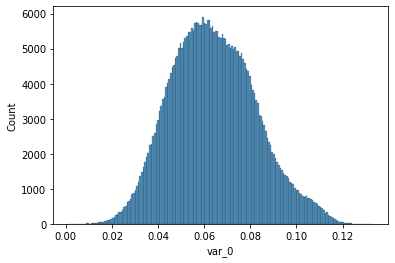

In [17]:
sns.histplot(x_scaled['var_0'])

<AxesSubplot:xlabel='var_23', ylabel='Count'>

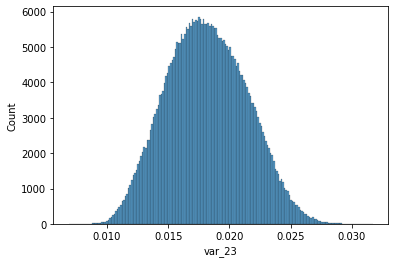

In [18]:
sns.histplot(x_scaled['var_23'])

In [19]:
train_x = x_scaled[:train_shape[0]]
test_x = x_scaled[:test_shape[0]]

train_y = train_data['target']

In [20]:
train_x.shape
test_x.shape

(200000, 200)

In [21]:
def identity_block(X, hidden_layers):
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = BatchNormalization() (X)
    X = X_shortcut

    for i in range(len(hidden_layers)):

        X = Dense(hidden_layers[i], activation='relu') (X)
        X = Dropout(0.8) (X)
        X = BatchNormalization() (X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [22]:
def model(input_shape, hidden_layers):
    X_input = Input(input_shape[1])
    X= Reshape((1,input_shape[1], ) , input_shape=input_shape)(X_input)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(256, return_sequences=True)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.1)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(24, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.1)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(1, activation='sigmoid')(X)
    # Create model
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    return model

In [23]:




# load YAML and create model

try: 
    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    print ("model.json loaded")
    loaded_model = model_from_json(loaded_model_json)
    print ("model.json converted")


    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model weights from disk")
    model = loaded_model
except Exception as e: 
    print('Failed to load model: '+ str(e))
    
    print("Model not found on disk, creating new model")


    hidden_layers = [ 100, 30, 200]


    model = model(train_x.shape, hidden_layers)
    
    

Failed to load model: [Errno 2] No such file or directory: 'model.json'
Model not found on disk, creating new model


In [24]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience= 15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)



# fit the keras model on the dataset
history = model.fit(train_x, train_y, validation_split=0.05, epochs=90000, batch_size=2000, verbose = 0 , callbacks=[es, mc])

KeyboardInterrupt: 

<AxesSubplot:>

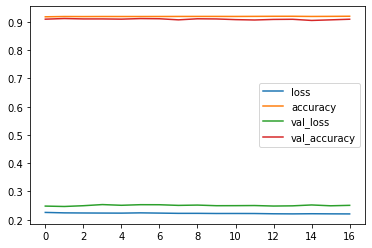

In [156]:
historial = pd.DataFrame(history.history)

historial.plot()

In [ ]:
model.evaluate()


In [157]:
target = (model.predict(test_x) > 0.5).astype("int32")

In [158]:
submission = pd.read_csv("./sample_submission.csv")
submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [159]:
submission['target'] = target

In [160]:
submission.to_csv('./submission.csv', index=False)

In [161]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
